In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import random as nprand
from cs771 import plotData as pd, utils, genSyntheticData as gsd
from keras.models import Sequential
from keras.layers import Dense as dense
from keras import optimizers

Using TensorFlow backend.


In [3]:
d = 2 
n = 20
r = 2

tmp1 = gsd.genSphericalData( d, n, [-5, -5], r )
tmp2 = gsd.genSphericalData( d, n, [5, 5], r )
XPos = np.vstack( (tmp1, tmp2) )
yPos = np.ones( (XPos.shape[0],) )

tmp1 = gsd.genSphericalData( d, n, [-5, 5], r )
tmp2 = gsd.genSphericalData( d, n, [5, -5], r )
XNeg = np.vstack( (tmp1, tmp2) )
yNeg = np.zeros( (XNeg.shape[0],) )

X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )
n = X.shape[0]
idx = nprand.permutation( n )

X = X[idx]
y = y[idx]

mu = np.mean( X, axis = 0 )
sigma = np.std( X, axis = 0 )

X -= mu
X /= sigma

Text(0, 0.5, 'Classification Accuracy')

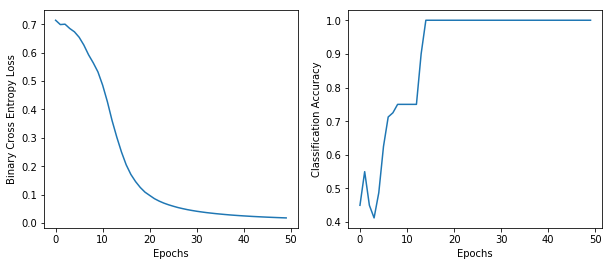

In [6]:
model = Sequential()
model.add( dense( units = 2, activation = "sigmoid", input_dim = 2, use_bias = True ) )
model.add( dense( units = 1, activation = "sigmoid", use_bias = True ) )
# Setting a very large learning rate lr may make the NN temperamental and cause
# it to converge to a local optima. Keras supports "callbacks" which allow the
# user to dynamically lower learning rate if progress has stalled
opt = optimizers.Adam( lr = 0.1, beta_1 = 0.9, beta_2 = 0.999, amsgrad = True )
# Metrics are just for sake of display, not for sake of training
# Set verbose = 1 or 2 to see metrics reported for every epoch of training
model.compile( loss = "binary_crossentropy", optimizer = opt, metrics = ["binary_accuracy"] )
history = model.fit( X, y, epochs = 50, batch_size = n//8, verbose = 0 )

fig0, ax0 = pd.getFigList( nrows = 1, ncols = 2, sizex = 5, sizey = 4 )
ax0[0].plot(history.history['loss'])
ax0[1].plot(history.history['binary_accuracy'])
ax0[0].set_xlabel( "Epochs" )
ax0[0].set_ylabel( "Binary Cross Entropy Loss" )
ax0[1].set_xlabel( "Epochs" )
ax0[1].set_ylabel( "Classification Accuracy" )

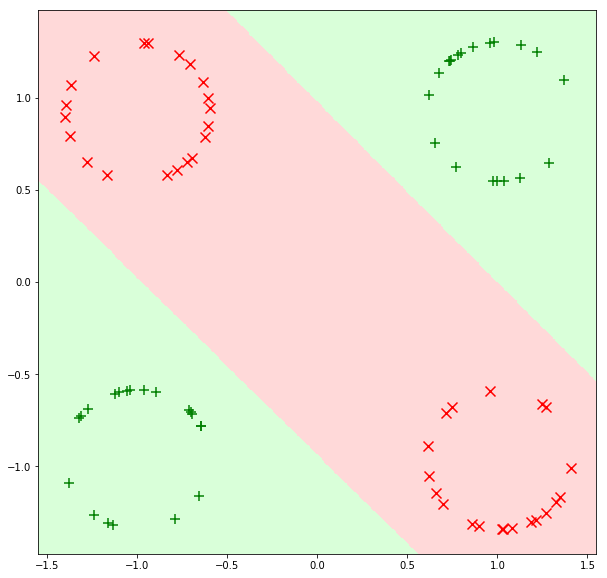

In [7]:
def ffpredict( X ):
    # Our shading code anyway converts predictions to [0,1] scores
    return model.predict_classes( X )

fig = pd.getFigure( 10, 10 )
(xlim, ylim) = np.max( np.abs( X ), axis = 0 ) * 1.1
pd.shade2D( ffpredict, fig, mode = "batch", xlim = xlim, ylim = ylim )
pd.plot2D( X[y == 1], fig, color = 'g', marker = '+' )
pd.plot2D( X[y == 0], fig, color = 'r', marker = 'x' )

[array([[6.5789165, 7.583052 ],
       [6.7110186, 7.8780293]], dtype=float32), array([-6.594924,  7.179639], dtype=float32)]
[array([[ 9.040882],
       [-7.977251]], dtype=float32), array([3.5339959], dtype=float32)]


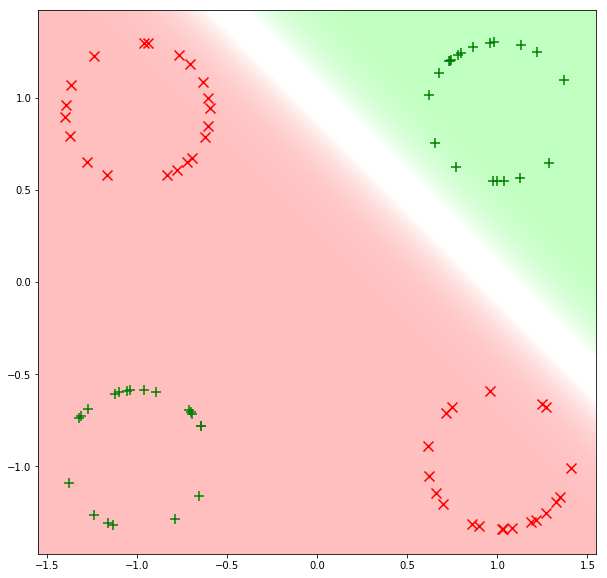

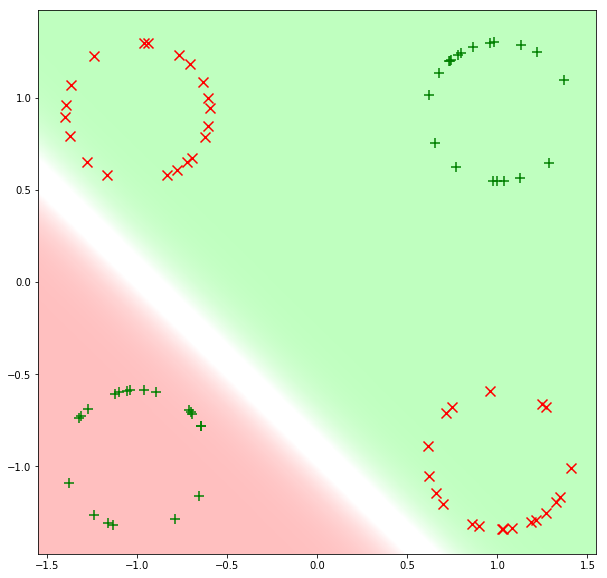

In [8]:
def sigmoid( a ):
    return 1/(1 + np.exp( -a ))

def getHiddenLayerActivations( X ):
    return sigmoid( X.dot( w ) + b )

w = model.layers[0].get_weights()[0][:,0]
b = model.layers[0].get_weights()[1][0]

fig2 = pd.getFigure( 10, 10 )
pd.shade2DProb( getHiddenLayerActivations, fig2, mode = "batch", xlim = xlim, ylim = ylim )
pd.plot2D( X[y == 1], fig2, color = 'g', marker = '+' )
pd.plot2D( X[y == 0], fig2, color = 'r', marker = 'x' )

w = model.layers[0].get_weights()[0][:,1]
b = model.layers[0].get_weights()[1][1]

fig3 = pd.getFigure( 10, 10 )
pd.shade2DProb( getHiddenLayerActivations, fig3, mode = "batch", xlim = xlim, ylim = ylim )
pd.plot2D( X[y == 1], fig3, color = 'g', marker = '+' )
pd.plot2D( X[y == 0], fig3, color = 'r', marker = 'x' )

# Note that the two nodes in the hidden layer cooperate to learn the classifier
# Neither node can fully classify the red points from the green points so they
# share the burden. Each node takes up the responsibility of isolating one red
# clump from the rest of the data. Together they make a perfect classifier :)
# One can interpret these two nodes as learning two useful features such that the
# learning problem become linearly separable when given these two new features
print( model.layers[0].get_weights() )
print( model.layers[1].get_weights() )